In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from torch.utils import data
import torch
import PIL
from PIL import Image
torch.manual_seed(42)
np.random.seed(42)

In [0]:
base_skin_dir = os.path.join('/', 'content/')

imageid_path_dict = {
    os.path.splitext(os.path.basename(filepath))[0]: filepath
    for filepath in glob(os.path.join('/content/', '*', '*.jpg')
)}

# imageid_path_dict = {
#     'path': '/content/'
# }
print(imageid_path_dict)
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'dermatofibroma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

{}


In [0]:
!pip install -U -q kaggle
!mkdir -p ~/.kaggle

from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"gieoon","key":"c959773a0a5fa1490ecffc6d1cd2cf60"}'}

In [0]:
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000/kernels

100% 2.61G/2.62G [00:46<00:00, 59.6MB/s]
100% 2.62G/2.62G [00:46<00:00, 60.5MB/s]


In [0]:
!unzip \*.zip

Archive:  skin-cancer-mnist-ham10000.zip
replace hmnist_28_28_RGB.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace HAM10000_metadata.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace HAM10000_images_part_1.zip? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: HAM10000_images_part_1.zip  

replace hmnist_28_28_L.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: error:  invalid response [{ENTER}]
replace hmnist_28_28_L.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace hmnist_8_8_L.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace HAM10000_images_part_2.zip? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: HAM10000_images_part_2.zip  
replace hmnist_8_8_RGB.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n

Archive:  HAM10000_images_part_2.zip
  inflating: ISIC_0029306.jpg        
  inflating: ISIC_0029307.jpg        
  inflating: ISIC_0029308.jpg        
  inflating: ISIC_0029309.jpg        
  inflating: ISIC_0029310.jpg        
  inflating: ISIC_0029311.jpg        
  inflating:

In [2]:
tile_df = pd.read_csv(os.path.join(base_skin_dir, 'HAM10000_metadata.csv'))
tile_df['path'] = '/content/' + tile_df['image_id'] + '.jpg'#.map(imageid_path_dict.get)
#print(base_skin_dir)
tile_df['cell_type'] = tile_df['dx'].map(lesion_type_dict.get) 
tile_df['cell_type_idx'] = pd.Categorical(tile_df['cell_type']).codes
print(tile_df['path'])

NameError: ignored

In [0]:
tile_df[['cell_type_idx', 'cell_type']].sort_values('cell_type_idx').drop_duplicates()

,cell_type_idx,cell_type
9804,0,Actinic keratoses
2528,1,Basal cell carcinoma
1018,2,Benign keratosis-like lesions
1159,3,Dermatofibroma
7050,4,Melanocytic nevi
2370,5,Vascular lesions
1577,6,dermatofibroma


In [0]:
tile_df['cell_type'].value_counts()

Melanocytic nevi                  6705
dermatofibroma                    1113
Benign keratosis-like lesions     1099
Basal cell carcinoma               514
Actinic keratoses                  327
Vascular lesions                   142
Dermatofibroma                     115
Name: cell_type, dtype: int64

In [0]:
tile_df.sample(3)

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
1617,HAM_0007180,ISIC_0033272,mel,histo,65.0,male,face,content/ISIC_0033272,dermatofibroma,6
8128,HAM_0007195,ISIC_0031923,nv,histo,40.0,female,lower extremity,content/ISIC_0031923,Melanocytic nevi,4
2168,HAM_0001835,ISIC_0026652,mel,histo,65.0,male,back,content/ISIC_0026652,dermatofibroma,6


In [1]:
tile_df['localization'].value_counts()

NameError: ignored

In [0]:
import torchvision.models as models
model_conv = models.resnet50(pretrained=True)

In [0]:
print(model_conv)

In [0]:
print(model_conv.fc)

Linear(in_features=2048, out_features=1000, bias=True)


In [0]:
num_ftrs = model_conv.fc.in_features
model_conv.fc = torch.nn.Linear(num_ftrs, 7) #change out classes to have the correct number of parameters

In [0]:
print(model_conv.fc)

Linear(in_features=2048, out_features=7, bias=True)


In [0]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(tile_df, test_size=0.1)
# We can split the test set again in a validation set and a true test set:
validation_df, test_df = train_test_split(test_df, test_size=0.5)
train_df = train_df.reset_index()
validation_df = validation_df.reset_index()
test_df = test_df.reset_index()

In [0]:
class Dataset(data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, df, transform=None):
        'Initialization'
        self.df = df
        self.transform = transform

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.df)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Load data and get label
        #print('path: ' + self.df['path'])
        X = Image.open(self.df['path'][index])
        y = torch.tensor(int(self.df['cell_type_idx'][index]))

        if self.transform:
            X = self.transform(X)

        return X, y

In [0]:
# Define the parameters for the dataloader
params = {'batch_size': 4,
          'shuffle': True,
          'num_workers': 6}

In [0]:
# define the transformation of the images.
import torchvision.transforms as trf
composed = trf.Compose([trf.RandomHorizontalFlip(), trf.RandomVerticalFlip(), trf.CenterCrop(256), trf.RandomCrop(224),  trf.ToTensor(),
                        trf.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

In [0]:
# Define the trainingsset using the table train_df and using our defined transitions (composed)
training_set = Dataset(train_df, transform=composed)
training_generator = torch.utils.data.DataLoader(dataset=training_set,**params)

# Same for the validation set:
validation_set = Dataset(validation_df, transform=composed)
validation_generator = torch.utils.data.DataLoader(dataset=validation_set, **params)

In [0]:
model = model_conv
optimizer = torch.optim.Adam(model.parameters(), lr=1e-6)
criterion = torch.nn.CrossEntropyLoss()

NameError: ignored

In [0]:
# test out a sample image
from IPython.display import Image
Image('/content/ISIC_0031331.jpg')



In [0]:
max_epochs = 20
trainings_error = []
validation_error = []
for epoch in range(max_epochs):
    print('epoch:', epoch)
    count_train = 0
    trainings_error_tmp = []
    model.train()
    for i, (data_sample, y) in enumerate(training_generator):
        output = model(data_sample)
        err = criterion(output, y)
        err.backward()
        optimizer.step()
        trainings_error_tmp.append(err.item())
        count_train += 1
        print('.', end = '')
#         if (i+1) % 10 == 0:                              # Logging
#             print('Epoch [%d/%d], Step [%d/%d], Loss: %.4f'
#                  %(epoch+1, max_epochs, i+1, len(training_generator)//batch_size, err.data[0]))
        if count_train >= 100:
            count_train = 0
            mean_trainings_error = np.mean(trainings_error_tmp)
            trainings_error.append(mean_trainings_error)
            print('trainings error:', mean_trainings_error)
            break
    print('-------------- VALIDATING -----------------------')
    with torch.set_grad_enabled(False):
        validation_error_tmp = []
        count_val = 0
        model.eval()
        for i, (data_sample, y) in enumerate(validation_generator):
            output = model(data_sample)
            err = criterion(output, y)
            validation_error_tmp.append(err.item())
            count_val += 1
            print('.', end = '')
            if count_val >= 10:
                count_val = 0
                mean_val_error = np.mean(validation_error_tmp)
                validation_error.append(mean_val_error)
                print('validation error:', mean_val_error)
                break
            

epoch: 0
....................................................................................................trainings error: 1.3780996924638749
-------------- VALIDATING -----------------------
..........validation error: 1.0042834818363189
epoch: 1
....................................................................................................trainings error: 1.160468063056469
-------------- VALIDATING -----------------------
..........validation error: 1.0053837299346924
epoch: 2
....................................................................................................trainings error: 1.1099398058652878
-------------- VALIDATING -----------------------
..........validation error: 0.8164050132036209
epoch: 3
....................................................................................................trainings error: 0.9162603163719177
-------------- VALIDATING -----------------------
..........validation error: 0.9016627401113511
epoch: 4
........................

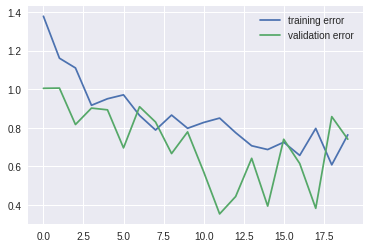

In [0]:
plt.plot(trainings_error, label = 'training error')
plt.plot(validation_error, label = 'validation error')
plt.legend()
plt.show()

In [0]:
model.eval()
test_set = Dataset(validation_df, transform=composed)
test_generator = data.SequentialSampler(validation_set)
print(test_generator)

In [0]:
result_array = []
gt_array = []
#iterating over dataset rather than the Dataloader, so have to unsqueeze to adjust the input dimensions
for i in test_generator:
    data_sample, y = validation_set.__getitem__(i)
    new_data_sample = data_sample.unsqueeze(0)#.to(device)
    output = model(new_data_sample)
    result = torch.argmax(output)
    result_array.append(result.item())
    gt_array.append(y.item())
    

In [0]:
correct_results = np.array(result_array)==np.array(gt_array)

In [0]:
sum_correct = np.sum(correct_results)

In [0]:
accuracy = sum_correct/test_generator.__len__()
print(accuracy)

0.8203592814371258


In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)





In [0]:
# 2. Save Keras Model or weights on Google Drive

# Create on Colab Directory
model.save('model.h5')
model_file = drive.CreateFile({'title' : 'model.h5'})
model_file.SetContentFile('model.h5')
model_file.Upload()

# Download to Google Drive
drive.CreateFile({'id' : model_file.get('id')})

In [0]:
# save Torch model or weights on Google Drive

torch.save(model.state_dict(), "./model.pth")
torch.save(optimizer.state_dict(), "./optimizer.pth")
'''
model_file = drive.CreateFile({'title' : 'model.pth'})
model_file.SetContentFile('./model.pth')
model_file.Upload()
drive.CreateFile({'id' : model_file.get('id')})

optimizer_file = drive.CreateFile({'title' : 'optimizer.pth'})
optimizer_file.SetContentFile('./optimizer.pth')
optimizer_file.Upload()
drive.CreateFile({'id' : optimizer_file.get('id')})
'''

"\nmodel_file = drive.CreateFile({'title' : 'model.pth'})\nmodel_file.SetContentFile('./model.pth')\nmodel_file.Upload()\ndrive.CreateFile({'id' : model_file.get('id')})\n\noptimizer_file = drive.CreateFile({'title' : 'optimizer.pth'})\noptimizer_file.SetContentFile('./optimizer.pth')\noptimizer_file.Upload()\ndrive.CreateFile({'id' : optimizer_file.get('id')})\n"